Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.226416 s


'compile' took 0.654868 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.52e-03, 5.09e+03, 3.02e+03, 4.77e-02]    [0.00e+00, 5.09e+03, 3.02e+03, 4.77e-02]    []  
1000      [9.82e-02, 4.45e+03, 2.53e+03, 1.23e+00]    [2.27e-15, 4.45e+03, 2.53e+03, 1.23e+00]    []  
2000      [4.17e-01, 4.18e+03, 2.33e+03, 2.89e-01]    [6.53e-16, 4.18e+03, 2.33e+03, 2.89e-01]    []  
3000      [1.05e+00, 4.05e+03, 2.24e+03, 2.14e-01]    [1.17e-15, 4.05e+03, 2.24e+03, 2.14e-01]    []  
4000      [1.46e+00, 3.97e+03, 2.18e+03, 1.33e-01]    [3.60e-16, 3.97e+03, 2.18e+03, 1.33e-01]    []  
5000      [1.45e+00, 3.90e+03, 2.13e+03, 8.69e-02]    [1.08e-16, 3.90e+03, 2.13e+03, 8.69e-02]    []  
6000      [1.37e+00, 3.85e+03, 2.09e+03, 7.74e-02]    [4.06e-16, 3.85e+03, 2.09e+03, 7.74e-02]    []  
7000      [8.95e-01, 3.80e+03, 2.06e+03, 2.75e-02]    [9.59e-17, 3.80e+03, 2.06e+03, 2.75e-02]   

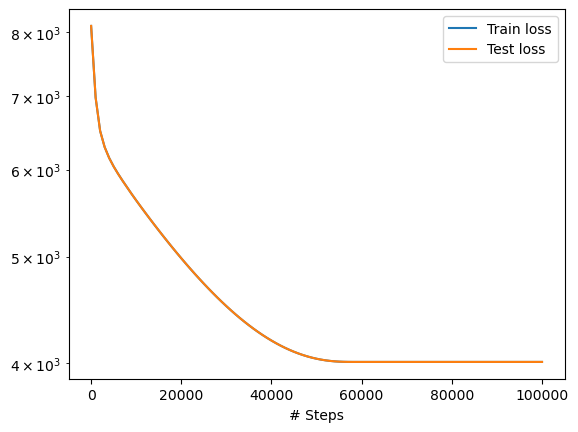

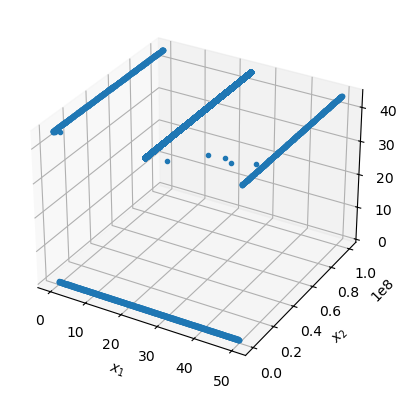

In [1]:
#Change to point dataset
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
import tensorflow as tf

# Set TensorFlow to use all available cores
num_cores = 20
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores,allow_soft_placement=True,device_count={'CPU': num_cores})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

D = 3.8e-11 #m^2/s
l = 50 #mm
t = 1e8 #s
geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (dy_t- D*dy_xx)

def fun_bc(x):
    return 100 - 100/l*x[:, 0:1]

def fun_init(x):
    return 0*x[:,0:1]

data_points = np.matrix([[0.05, 1e5, 9.86688614e-35],
                [0.35, 18e4, 2.80E-20],
                [25.4, 1214e4, 40.4857407],
                [40.75, 1848e4, 79.3099365],
                [48.35, 1999e4, 96.3708344],
                [0.6,24e4, 1.37249327e-17],
                [1.55,169e4, 0.0405000916],
                [30.15,267e4, 16.3269901],
                [43.2,1541e4, 83.7792282],
                [36.75,1704e4, 69.8383331]])

T=np.reshape(data_points[:, 1], (-1,1))
X=np.reshape(data_points[:, 0], (-1,1))
C=np.reshape(data_points[:, 2:], (-1,1))

bc = dde.icbc.DirichletBC(geomtime, lambda x: (x[:, 0:1]/ l) * 10, lambda _, on_boundary: on_boundary, component=0)
#bc_b = dde.icbc.DirichletBC(geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1)
ic = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=0)


observe_x= np.reshape(np.hstack((X,T)),(-1,2))
observe_y = dde.icbc.PointSetBC(observe_x, C, component=0)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, observe_y,ic],
    num_domain=2000,
    num_boundary=1000,
    num_initial=1000,
    num_test=50000,
)

layer_size = [2] + [64] * 5 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.00001)
losshistory, train_state = model.train(iterations=100000)
#early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
#losshistory, train_state = model.train(iterations=100, callbacks=[early_stopping])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



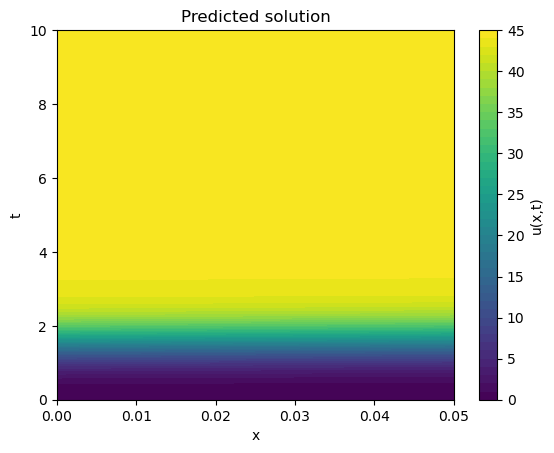

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\test.dat ...


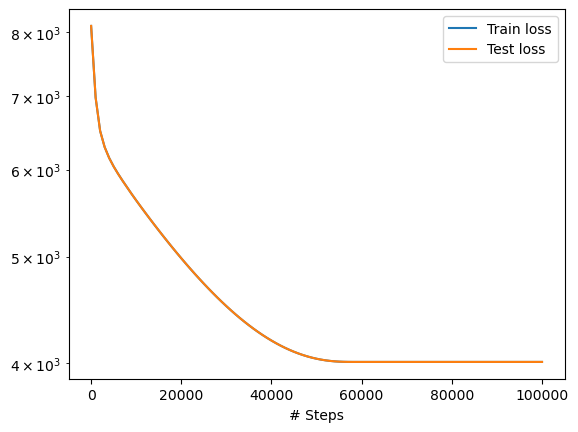

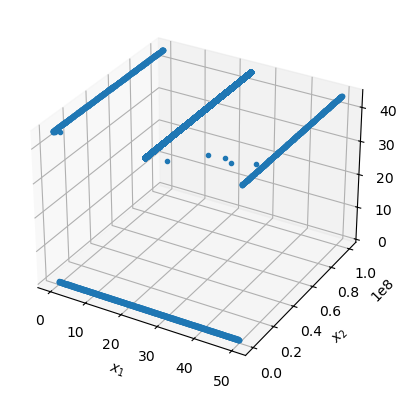

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.05, 100)
t = np.linspace(0, 10,100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

# Save the plot and loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...

'build' took 0.177525 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'compile' took 0.475833 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [7.24e-02, 1.65e-03, 0.00e+00, 1.00e+00]    [7.42e-02, 1.01e-03, 0.00e+00, 1.00e+00]    [1.08e+00]    
1000      [8.05e-03, 6.12e-03, 2.65e-10, 2.46e-04]    [8.89e-03, 6.02e-03, 2.65e-10, 2.46e-04]    [7.47e-01]    
2000      [5.01e-03, 4.29e-03, 2.10e-06, 9.11e-05]    [5.15e-03, 4.48e-03, 2.10e-06, 9.11e-05]    [5.76e-01]    
3000      [1.10e-03, 1.56e-03, 1.41e-06, 1.86e-05]    [1.19e-03, 1.36e-03, 1.41e-06, 1.86e-05]    [2.66e-01]    
4000      [8.40e-05, 1.00e-04, 1.63e-07, 3.91e-07]    [7.95e-05, 6.56e-05, 1.63e-07, 3.91e-07]    [4.59e-02]    
5000      [3.54e-05, 2.40e-05, 3.91e-08, 2.52e-08]    [3.04e-05, 1.84e-05, 3.91e-08, 2.52e-08]    [1.49e-02]    
6000      [1.90e-05, 7.61e-06, 9.23e-09, 5.69e-09]    [1.62e-05, 5.72e-06, 9.23e-09, 5.69e-09]    [7.19e-03]    
7000      [1.12e-05, 3.35e-06, 1.29e-08, 1.49e-08

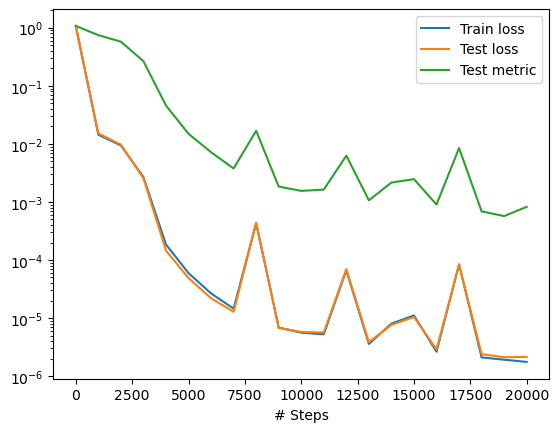

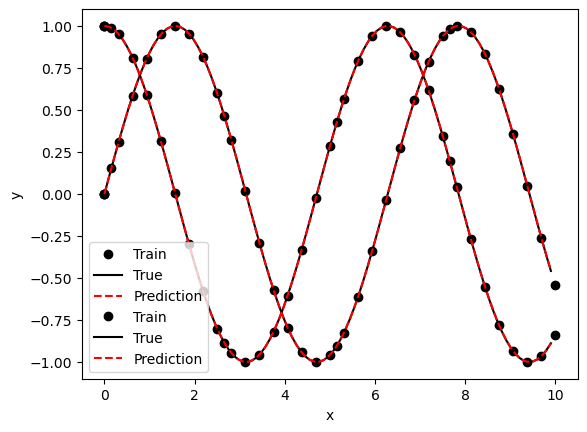

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""

import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np
import os

def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    # Most backends
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # y1, y2 = y_val[:, 0:1], y_val[:, 1:]
    # dy1_x, _ = dde.grad.jacobian(y, x, i=0)
    # dy2_x, _ = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
